# Surgical Gesture Recognition - Results Visualization

This notebook visualizes the results from trained models on the JIGSAWS dataset:
- Embedding visualizations (t-SNE, UMAP, PCA)
- Evaluation metrics bar plots
- Confusion matrices
- Loss curves
- Per-gesture and per-skill performance

In [1]:
import sys
import os
from pathlib import Path

# Add src to path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
sys.path.insert(0, str(project_root / 'src'))

print(f"Project root: {project_root}")

Project root: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures


In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import pickle
import re
from typing import Dict, List, Tuple

# Try to import UMAP
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("UMAP not available. Install with: pip install umap-learn")

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Configuration

In [3]:
# Configuration - Update these paths as needed
TASKS = ['Knot_Tying', 'Needle_Passing', 'Suturing']
SPLIT = 'fold_1'
MODE = 'test'

# Directories
CHECKPOINT_DIR = project_root / 'checkpoints'
EVAL_RESULTS_DIR = project_root / 'eval_results'
EMBEDDINGS_DIR = project_root / 'embeddings'
PLOTS_DIR = project_root / 'plots' / 'results'

# Create output directory
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Gesture labels (JIGSAWS) - Short codes
GESTURE_LABELS = {
    0: 'G1', 1: 'G2', 2: 'G3', 3: 'G4', 4: 'G5',
    5: 'G6', 6: 'G7', 7: 'G8', 8: 'G9', 9: 'G10',
    10: 'G11', 11: 'G12', 12: 'G13', 13: 'G14', 14: 'G15'
}

# Full gesture descriptions
GESTURE_DESCRIPTIONS = {
    'G1': 'Reaching for needle with right hand',
    'G2': 'Positioning the tip of the needle',
    'G3': 'Pushing needle through tissue',
    'G4': 'Transferring needle from left to right',
    'G5': 'Moving to center with needle in grip',
    'G6': 'Pulling suture with left hand',
    'G7': 'Pulling suture with right hand',
    'G8': 'Orienting needle',
    'G9': 'Using right hand to help tighten suture',
    'G10': 'Loosening more suture',
    'G11': 'Dropping suture and moving to end points',
    'G12': 'Reaching for needle with left hand',
    'G13': 'Making C loop around right hand',
    'G14': 'Reaching for suture with right hand',
    'G15': 'Pulling suture with both hands'
}

# Gestures used per task
TASK_GESTURES = {
    'Knot_Tying': ['G1', 'G11', 'G12', 'G13', 'G14', 'G15'],
    'Needle_Passing': ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G8', 'G11'],
    'Suturing': ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G8', 'G9', 'G10', 'G11']
}

SKILL_LABELS = {0: 'Novice', 1: 'Intermediate', 2: 'Expert'}

# Colors for tasks
TASK_COLORS = {
    'Knot_Tying': '#2ecc71',
    'Needle_Passing': '#3498db', 
    'Suturing': '#e74c3c'
}

print(f"Tasks: {TASKS}")
print(f"Split: {SPLIT}")
print(f"Plots will be saved to: {PLOTS_DIR}")

Tasks: ['Knot_Tying', 'Needle_Passing', 'Suturing']
Split: fold_1
Plots will be saved to: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results


## 1.1 JIGSAWS Gesture Reference

The JIGSAWS dataset defines 15 surgical gestures (G1-G15) that represent atomic surgical actions. Each task uses a subset of these gestures.

In [4]:
# Create styled gesture reference table
def display_gesture_reference():
    """Display a formatted gesture reference table."""
    
    # Create main gesture table
    gesture_data = []
    for i in range(1, 16):
        gid = f'G{i}'
        desc = GESTURE_DESCRIPTIONS.get(gid, 'N/A')
        
        # Check which tasks use this gesture
        kt = '✓' if gid in TASK_GESTURES['Knot_Tying'] else ''
        np_task = '✓' if gid in TASK_GESTURES['Needle_Passing'] else ''
        su = '✓' if gid in TASK_GESTURES['Suturing'] else ''
        
        gesture_data.append({
            'Gesture': gid,
            'Description': desc,
            'Knot Tying': kt,
            'Needle Passing': np_task,
            'Suturing': su
        })
    
    df_gestures = pd.DataFrame(gesture_data)
    
    # Style the dataframe
    def highlight_tasks(val):
        if val == '✓':
            return 'background-color: #d4edda; color: #155724; font-weight: bold; text-align: center'
        return 'text-align: center'
    
    styled_df = df_gestures.style.applymap(
        highlight_tasks, 
        subset=['Knot Tying', 'Needle Passing', 'Suturing']
    ).set_properties(**{
        'text-align': 'left',
        'color': 'black'
    }, subset=['Gesture', 'Description']).set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#343a40'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('padding', '10px')
        ]},
        {'selector': 'td', 'props': [
            ('padding', '8px'),
            ('border', '1px solid #dee2e6'),
            ('color', 'black')
        ]},
        {'selector': 'tr:nth-of-type(even)', 'props': [
            ('background-color', '#f8f9fa')
        ]},
        {'selector': 'tr:nth-of-type(odd)', 'props': [
            ('background-color', 'white')
        ]},
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '1.2em'),
            ('font-weight', 'bold'),
            ('padding', '10px'),
            ('color', 'black')
        ]}
    ]).set_caption('JIGSAWS Gesture Vocabulary Reference')
    
    return styled_df

# Display the gesture reference table
print("=" * 80)
print("JIGSAWS GESTURE REFERENCE TABLE")
print("=" * 80)
display_gesture_reference()

JIGSAWS GESTURE REFERENCE TABLE


/var/folders/yl/pwzbfdbj3t750krq7cky4n5c0000gn/T/ipykernel_64308/2855686339.py:32: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = df_gestures.style.applymap(


,Gesture,Description,Knot Tying,Needle Passing,Suturing
0,G1,Reaching for needle with right hand,✓,✓,✓
1,G2,Positioning the tip of the needle,,✓,✓
2,G3,Pushing needle through tissue,,✓,✓
3,G4,Transferring needle from left to right,,✓,✓
4,G5,Moving to center with needle in grip,,✓,✓
5,G6,Pulling suture with left hand,,✓,✓
6,G7,Pulling suture with right hand,,,
7,G8,Orienting needle,,✓,✓
8,G9,Using right hand to help tighten suture,,,✓
9,G10,Loosening more suture,,,✓


In [5]:
# Task-specific gesture summary
def display_task_gesture_summary():
    """Display gestures used in each task with descriptions."""
    
    for task in TASKS:
        task_display = task.replace('_', ' ')
        gestures = TASK_GESTURES[task]
        
        print(f"\n{'─'*70}")
        print(f"  {task_display.upper()}")
        print(f"  {len(gestures)} gestures: {', '.join(gestures)}")
        print(f"{'─'*70}")
        
        task_data = []
        for gid in gestures:
            task_data.append({
                'Gesture': gid,
                'Description': GESTURE_DESCRIPTIONS[gid]
            })
        
        df = pd.DataFrame(task_data)
        display(df.style.set_properties(**{
            'text-align': 'left',
            'padding': '5px'
        }).hide(axis='index').set_table_styles([
            {'selector': 'th', 'props': [
                ('background-color', TASK_COLORS[task]),
                ('color', 'white'),
                ('padding', '8px')
            ]}
        ]))

print("\n" + "=" * 80)
print("GESTURES BY TASK")
print("=" * 80)
display_task_gesture_summary()


GESTURES BY TASK

──────────────────────────────────────────────────────────────────────
  KNOT TYING
  6 gestures: G1, G11, G12, G13, G14, G15
──────────────────────────────────────────────────────────────────────


Gesture,Description
G1,Reaching for needle with right hand
G11,Dropping suture and moving to end points
G12,Reaching for needle with left hand
G13,Making C loop around right hand
G14,Reaching for suture with right hand
G15,Pulling suture with both hands



──────────────────────────────────────────────────────────────────────
  NEEDLE PASSING
  8 gestures: G1, G2, G3, G4, G5, G6, G8, G11
──────────────────────────────────────────────────────────────────────


Gesture,Description
G1,Reaching for needle with right hand
G2,Positioning the tip of the needle
G3,Pushing needle through tissue
G4,Transferring needle from left to right
G5,Moving to center with needle in grip
G6,Pulling suture with left hand
G8,Orienting needle
G11,Dropping suture and moving to end points



──────────────────────────────────────────────────────────────────────
  SUTURING
  10 gestures: G1, G2, G3, G4, G5, G6, G8, G9, G10, G11
──────────────────────────────────────────────────────────────────────


Gesture,Description
G1,Reaching for needle with right hand
G2,Positioning the tip of the needle
G3,Pushing needle through tissue
G4,Transferring needle from left to right
G5,Moving to center with needle in grip
G6,Pulling suture with left hand
G8,Orienting needle
G9,Using right hand to help tighten suture
G10,Loosening more suture
G11,Dropping suture and moving to end points


In [6]:
# Skill level reference
print("\n" + "=" * 80)
print("SKILL LEVEL DEFINITIONS")
print("=" * 80)

skill_data = [
    {'Level': 'Novice (N)', 'Experience': '< 10 hours', 'Description': 'Beginner surgeons with limited robotic surgery experience'},
    {'Level': 'Intermediate (I)', 'Experience': '10-100 hours', 'Description': 'Surgeons with moderate robotic surgery experience'},
    {'Level': 'Expert (E)', 'Experience': '> 100 hours', 'Description': 'Experienced surgeons proficient in robotic surgery'}
]

df_skills = pd.DataFrame(skill_data)
display(df_skills.style.set_properties(**{
    'text-align': 'left',
    'padding': '8px'
}).hide(axis='index').set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#6c757d'),
        ('color', 'white'),
        ('padding', '10px'),
        ('font-weight', 'bold')
    ]},
    {'selector': 'td', 'props': [
        ('border', '1px solid #dee2e6')
    ]}
]).set_caption('JIGSAWS Skill Level Classification'))


SKILL LEVEL DEFINITIONS


Level,Experience,Description
Novice (N),< 10 hours,Beginner surgeons with limited robotic surgery experience
Intermediate (I),10-100 hours,Surgeons with moderate robotic surgery experience
Expert (E),> 100 hours,Experienced surgeons proficient in robotic surgery


## 2. Load Evaluation Results

In [7]:
def parse_eval_results(file_path: Path) -> Dict:
    """Parse evaluation results from text file."""
    results = {
        'losses': {},
        'kinematics': {},
        'gesture': {},
        'skill': {}
    }
    
    if not file_path.exists():
        print(f"File not found: {file_path}")
        return None
    
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Parse losses
    total_loss = re.search(r'Total Loss: ([\d.]+)', content)
    if total_loss:
        results['losses']['total'] = float(total_loss.group(1))
    
    kin_loss = re.search(r'Kinematics Loss: ([\d.]+)', content)
    if kin_loss:
        results['losses']['kinematics'] = float(kin_loss.group(1))
    
    gesture_loss = re.search(r'Gesture Loss: ([\d.]+)', content)
    if gesture_loss:
        results['losses']['gesture'] = float(gesture_loss.group(1))
    
    skill_loss = re.search(r'Skill Loss: ([\d.]+)', content)
    if skill_loss:
        results['losses']['skill'] = float(skill_loss.group(1))
    
    # Parse kinematics metrics
    pos_rmse = re.search(r'Position RMSE: ([\d.]+)', content)
    if pos_rmse:
        results['kinematics']['pos_rmse'] = float(pos_rmse.group(1))
    
    ee_error = re.search(r'End-Effector Error: ([\d.]+)', content)
    if ee_error:
        results['kinematics']['ee_error'] = float(ee_error.group(1))
    
    rot_rmse = re.search(r'Rotation RMSE: ([\d.]+)', content)
    if rot_rmse:
        results['kinematics']['rot_rmse'] = float(rot_rmse.group(1))
    
    # Parse gesture metrics
    gesture_acc = re.search(r'Gesture Classification:[\s\S]*?Accuracy: ([\d.]+)%', content)
    if gesture_acc:
        results['gesture']['accuracy'] = float(gesture_acc.group(1))
    
    gesture_f1_macro = re.search(r'Gesture Classification:[\s\S]*?F1 \(Macro\): ([\d.]+)', content)
    if gesture_f1_macro:
        results['gesture']['f1_macro'] = float(gesture_f1_macro.group(1))
    
    gesture_f1_micro = re.search(r'Gesture Classification:[\s\S]*?F1 \(Micro\): ([\d.]+)', content)
    if gesture_f1_micro:
        results['gesture']['f1_micro'] = float(gesture_f1_micro.group(1))
    
    # Parse skill metrics
    skill_acc = re.search(r'Skill Classification:[\s\S]*?Accuracy: ([\d.]+)%', content)
    if skill_acc:
        results['skill']['accuracy'] = float(skill_acc.group(1))
    
    skill_f1 = re.search(r'Skill Classification:[\s\S]*?F1 \(Macro\): ([\d.]+)', content)
    if skill_f1:
        results['skill']['f1_macro'] = float(skill_f1.group(1))
    
    return results

# Load results for all tasks
all_results = {}
for task in TASKS:
    result_file = EVAL_RESULTS_DIR / f"{task}_{MODE}_{SPLIT}_results.txt"
    results = parse_eval_results(result_file)
    if results:
        all_results[task] = results
        print(f"✓ Loaded results for {task}")
    else:
        print(f"✗ No results found for {task}")

print(f"\nLoaded results for {len(all_results)} tasks")

✓ Loaded results for Knot_Tying
✓ Loaded results for Needle_Passing
✓ Loaded results for Suturing

Loaded results for 3 tasks


In [8]:
# Display results as a table
if all_results:
    data = []
    for task, results in all_results.items():
        row = {
            'Task': task,
            'Total Loss': results['losses'].get('total', np.nan),
            'Kin Loss': results['losses'].get('kinematics', np.nan),
            'Pos RMSE': results['kinematics'].get('pos_rmse', np.nan),
            'Rot RMSE': results['kinematics'].get('rot_rmse', np.nan),
            'Gesture Acc (%)': results['gesture'].get('accuracy', np.nan),
            'Gesture F1': results['gesture'].get('f1_macro', np.nan),
            'Skill Acc (%)': results['skill'].get('accuracy', np.nan),
            'Skill F1': results['skill'].get('f1_macro', np.nan),
        }
        data.append(row)
    
    df_results = pd.DataFrame(data)
    display(df_results.round(4))

,Task,Total Loss,Kin Loss,Pos RMSE,Rot RMSE,Gesture Acc (%),Gesture F1,Skill Acc (%),Skill F1
0,Knot_Tying,0.6310,0.0689,0.0187,0.8717,100.0,1.0000,100.0,1.0
1,Needle_Passing,1.1441,0.1458,0.0366,0.7119,79.1,0.7916,100.0,1.0
2,Suturing,0.6317,0.0723,0.0131,1.1634,100.0,1.0000,100.0,1.0


## 3. Bar Plots for Evaluation Metrics

In [9]:
def plot_metric_comparison(all_results: Dict, metric_path: List[str], 
                           title: str, ylabel: str, filename: str,
                           percentage: bool = False):
    """Create a bar plot comparing a metric across tasks."""
    tasks = list(all_results.keys())
    values = []
    
    for task in tasks:
        result = all_results[task]
        value = result
        for key in metric_path:
            value = value.get(key, {})
        values.append(value if isinstance(value, (int, float)) else 0)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = [TASK_COLORS.get(task, '#95a5a6') for task in tasks]
    bars = ax.bar(tasks, values, color=colors, edgecolor='black', linewidth=1.2)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        label = f'{value:.1f}%' if percentage else f'{value:.4f}'
        ax.annotate(label,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('Task', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Clean up task names for display
    ax.set_xticklabels([t.replace('_', ' ') for t in tasks])
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {PLOTS_DIR / filename}")

/var/folders/yl/pwzbfdbj3t750krq7cky4n5c0000gn/T/ipykernel_64308/3658392223.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.replace('_', ' ') for t in tasks])


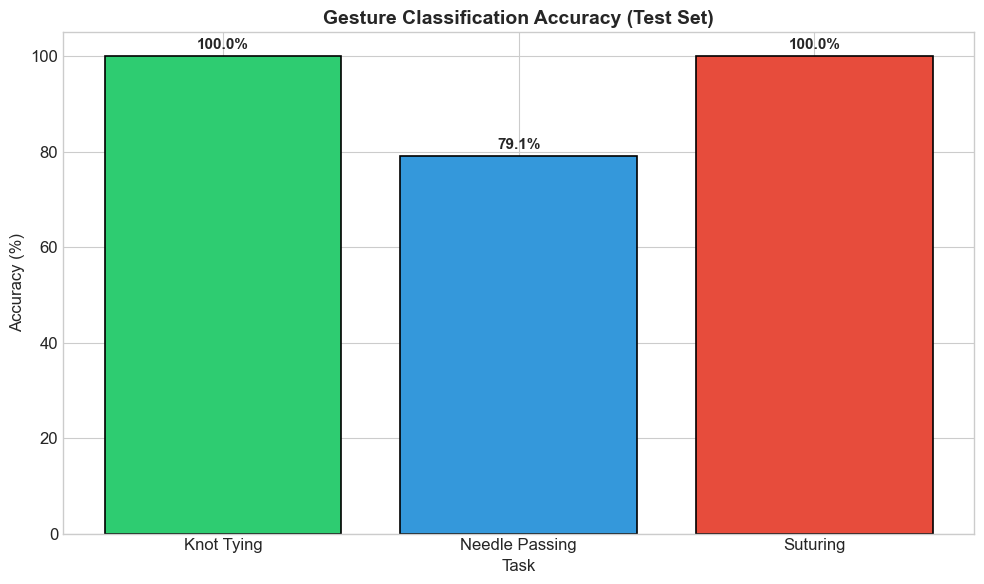

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/gesture_accuracy_test_fold_1.png


In [10]:
if all_results:
    # Gesture Classification Accuracy
    plot_metric_comparison(
        all_results, 
        ['gesture', 'accuracy'],
        f'Gesture Classification Accuracy ({MODE.title()} Set)',
        'Accuracy (%)',
        f'gesture_accuracy_{MODE}_{SPLIT}.png',
        percentage=True
    )

/var/folders/yl/pwzbfdbj3t750krq7cky4n5c0000gn/T/ipykernel_64308/3658392223.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.replace('_', ' ') for t in tasks])


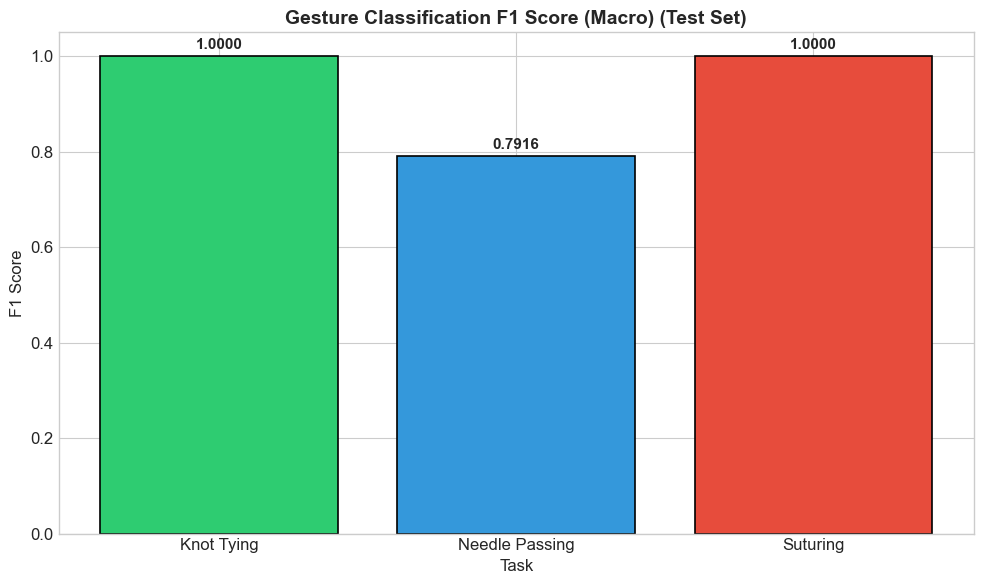

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/gesture_f1_test_fold_1.png


In [11]:
if all_results:
    # Gesture F1 Score
    plot_metric_comparison(
        all_results,
        ['gesture', 'f1_macro'],
        f'Gesture Classification F1 Score (Macro) ({MODE.title()} Set)',
        'F1 Score',
        f'gesture_f1_{MODE}_{SPLIT}.png'
    )

/var/folders/yl/pwzbfdbj3t750krq7cky4n5c0000gn/T/ipykernel_64308/3658392223.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.replace('_', ' ') for t in tasks])


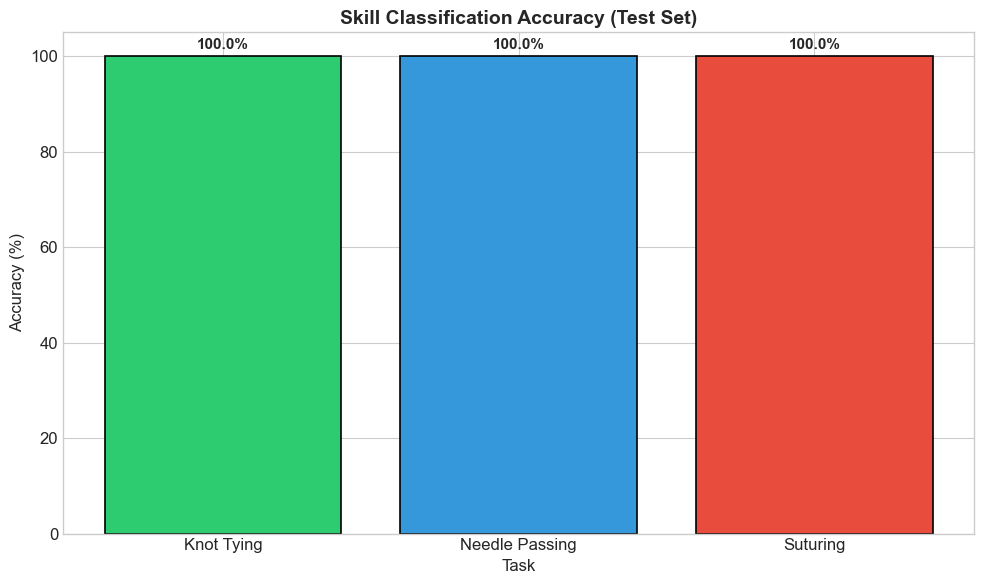

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/skill_accuracy_test_fold_1.png


In [12]:
if all_results:
    # Skill Classification Accuracy
    plot_metric_comparison(
        all_results,
        ['skill', 'accuracy'],
        f'Skill Classification Accuracy ({MODE.title()} Set)',
        'Accuracy (%)',
        f'skill_accuracy_{MODE}_{SPLIT}.png',
        percentage=True
    )

/var/folders/yl/pwzbfdbj3t750krq7cky4n5c0000gn/T/ipykernel_64308/3658392223.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([t.replace('_', ' ') for t in tasks])


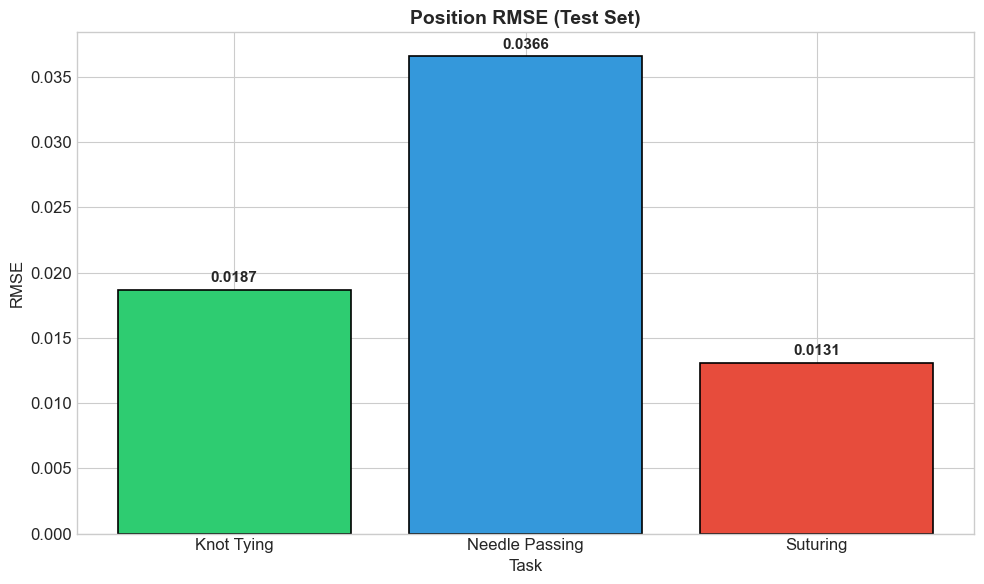

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/position_rmse_test_fold_1.png


In [13]:
if all_results:
    # Position RMSE
    plot_metric_comparison(
        all_results,
        ['kinematics', 'pos_rmse'],
        f'Position RMSE ({MODE.title()} Set)',
        'RMSE',
        f'position_rmse_{MODE}_{SPLIT}.png'
    )

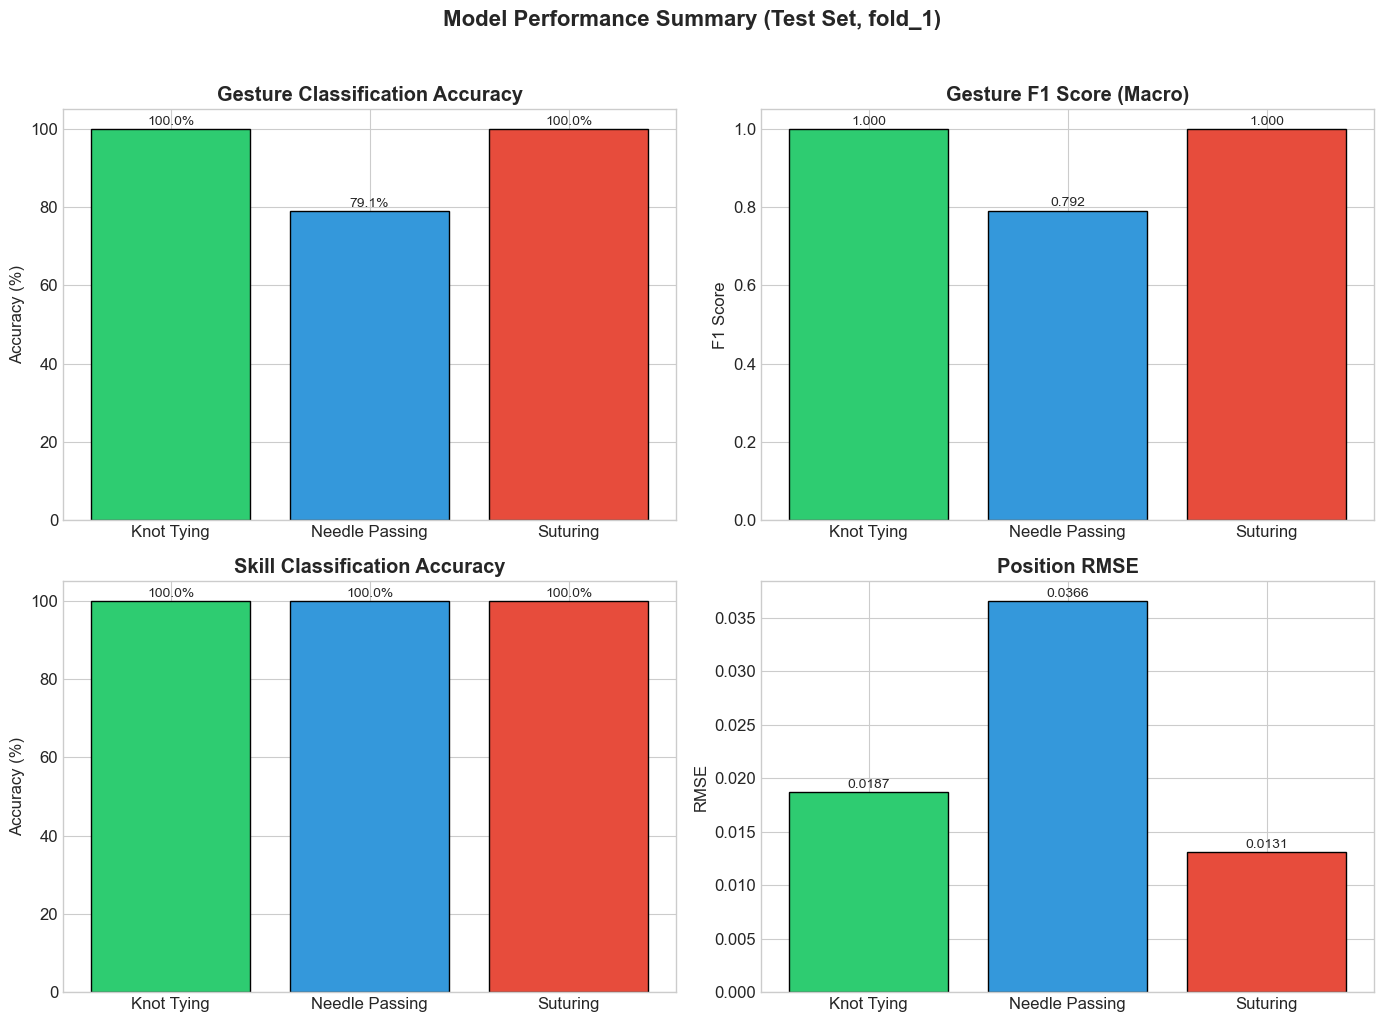

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/performance_summary_test_fold_1.png


In [14]:
# Combined metrics plot
if all_results:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    tasks = list(all_results.keys())
    task_labels = [t.replace('_', ' ') for t in tasks]
    colors = [TASK_COLORS.get(task, '#95a5a6') for task in tasks]
    
    # Gesture Accuracy
    ax = axes[0, 0]
    values = [all_results[t]['gesture'].get('accuracy', 0) for t in tasks]
    bars = ax.bar(task_labels, values, color=colors, edgecolor='black')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Gesture Classification Accuracy', fontweight='bold')
    for bar, v in zip(bars, values):
        ax.annotate(f'{v:.1f}%', xy=(bar.get_x() + bar.get_width()/2, v),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)
    
    # Gesture F1
    ax = axes[0, 1]
    values = [all_results[t]['gesture'].get('f1_macro', 0) for t in tasks]
    bars = ax.bar(task_labels, values, color=colors, edgecolor='black')
    ax.set_ylabel('F1 Score')
    ax.set_title('Gesture F1 Score (Macro)', fontweight='bold')
    for bar, v in zip(bars, values):
        ax.annotate(f'{v:.3f}', xy=(bar.get_x() + bar.get_width()/2, v),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)
    
    # Skill Accuracy
    ax = axes[1, 0]
    values = [all_results[t]['skill'].get('accuracy', 0) for t in tasks]
    bars = ax.bar(task_labels, values, color=colors, edgecolor='black')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Skill Classification Accuracy', fontweight='bold')
    for bar, v in zip(bars, values):
        ax.annotate(f'{v:.1f}%', xy=(bar.get_x() + bar.get_width()/2, v),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)
    
    # Position RMSE
    ax = axes[1, 1]
    values = [all_results[t]['kinematics'].get('pos_rmse', 0) for t in tasks]
    bars = ax.bar(task_labels, values, color=colors, edgecolor='black')
    ax.set_ylabel('RMSE')
    ax.set_title('Position RMSE', fontweight='bold')
    for bar, v in zip(bars, values):
        ax.annotate(f'{v:.4f}', xy=(bar.get_x() + bar.get_width()/2, v),
                    xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)
    
    plt.suptitle(f'Model Performance Summary ({MODE.title()} Set, {SPLIT})', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'performance_summary_{MODE}_{SPLIT}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {PLOTS_DIR / f'performance_summary_{MODE}_{SPLIT}.png'}")

## 4. Embedding Visualizations

In [15]:
def load_embeddings(embedding_path: Path) -> Dict:
    """Load embeddings from pickle file."""
    if not embedding_path.exists():
        print(f"Embedding file not found: {embedding_path}")
        return None
    
    with open(embedding_path, 'rb') as f:
        embeddings = pickle.load(f)
    return embeddings

def prepare_embeddings(embeddings: np.ndarray, aggregate: str = 'mean') -> np.ndarray:
    """Prepare embeddings for visualization by handling temporal dimension."""
    if len(embeddings.shape) == 2:
        return embeddings
    elif len(embeddings.shape) == 3:
        if aggregate == 'mean':
            return embeddings.mean(axis=1)
        elif aggregate == 'first':
            return embeddings[:, 0, :]
        elif aggregate == 'last':
            return embeddings[:, -1, :]
    return embeddings

# Check for available embedding files
print("Available embedding files:")
if EMBEDDINGS_DIR.exists():
    for f in EMBEDDINGS_DIR.glob('*.pkl'):
        print(f"  - {f.name}")
else:
    print(f"  Embeddings directory not found: {EMBEDDINGS_DIR}")
    print("  Run extract_embeddings.py first to generate embeddings.")

Available embedding files:
  - knot_tying_embeddings_old.pkl
  - needle_passing_test_fold_1_embeddings.pkl
  - suturing_test_fold_1_embeddings.pkl
  - knot_tying_test_fold_1_embeddings.pkl
  - needle_pass_embeddings_old.pkl


In [16]:
def plot_embeddings_2d(embeddings_2d: np.ndarray, labels: np.ndarray, 
                       label_names: Dict, title: str, ax=None,
                       colormap: str = 'tab20'):
    """Plot 2D embeddings colored by labels."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    unique_labels = np.unique(labels)
    n_labels = len(unique_labels)
    colors = plt.cm.get_cmap(colormap)(np.linspace(0, 1, max(n_labels, 10)))
    
    for idx, label in enumerate(unique_labels):
        mask = labels == label
        label_name = label_names.get(int(label), f"Label {label}")
        ax.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[colors[idx % len(colors)]],
            label=label_name,
            alpha=0.7,
            s=50,
            edgecolors='black',
            linewidths=0.5
        )
    
    ax.set_xlabel('Dimension 1', fontsize=11)
    ax.set_ylabel('Dimension 2', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    return ax

In [17]:
# Plot embeddings for each task
for task in TASKS:
    task_lower = task.lower()
    embedding_file = EMBEDDINGS_DIR / f"{task_lower}_embeddings.pkl"
    
    if not embedding_file.exists():
        # Try alternative naming
        embedding_file = EMBEDDINGS_DIR / f"{task}_embeddings.pkl"
    
    if not embedding_file.exists():
        print(f"\nNo embeddings found for {task}")
        continue
    
    print(f"\n{'='*60}")
    print(f"Loading embeddings for {task}")
    print(f"{'='*60}")
    
    emb_data = load_embeddings(embedding_file)
    if emb_data is None:
        continue
    
    # Print available embeddings
    print("Available embedding types:")
    for key, value in emb_data.items():
        if isinstance(value, np.ndarray):
            print(f"  - {key}: {value.shape}")
    
    # Get labels
    gesture_labels = emb_data.get('gesture_label', None)
    skill_labels = emb_data.get('skill_label', None)
    
    # Use mean_pooled embeddings
    emb_key = 'mean_pooled' if 'mean_pooled' in emb_data else list(emb_data.keys())[0]
    embeddings = emb_data[emb_key]
    embeddings = prepare_embeddings(embeddings)
    
    print(f"\nUsing '{emb_key}' embeddings with shape {embeddings.shape}")
    
    # t-SNE projection
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1), 
                random_state=42, max_iter=1000)
    emb_tsne = tsne.fit_transform(embeddings)
    
    # Plot by gesture
    if gesture_labels is not None:
        fig, ax = plt.subplots(figsize=(12, 10))
        plot_embeddings_2d(emb_tsne, gesture_labels, GESTURE_LABELS, 
                          f'{task.replace("_", " ")} - t-SNE (by Gesture)', ax)
        plt.tight_layout()
        save_path = PLOTS_DIR / f'{task_lower}_tsne_gesture.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: {save_path}")
    
    # Plot by skill
    if skill_labels is not None:
        fig, ax = plt.subplots(figsize=(12, 10))
        plot_embeddings_2d(emb_tsne, skill_labels, SKILL_LABELS,
                          f'{task.replace("_", " ")} - t-SNE (by Skill)', ax)
        plt.tight_layout()
        save_path = PLOTS_DIR / f'{task_lower}_tsne_skill.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Saved: {save_path}")


No embeddings found for Knot_Tying

No embeddings found for Needle_Passing

No embeddings found for Suturing


## 5. Confusion Matrix Generation

In [18]:
def generate_predictions_from_checkpoint(checkpoint_path: Path, task: str, 
                                         split: str, mode: str = 'test'):
    """Load model and generate predictions for confusion matrix."""
    from training.train_vit_system import EEGInformedViTModel
    from data import JIGSAWSViTDataset
    from data.split_loader import SplitLoader
    from torch.utils.data import DataLoader, Subset
    
    # Device
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    config = checkpoint['config']
    
    # Create model
    model = EEGInformedViTModel(config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Load dataset
    full_dataset = JIGSAWSViTDataset(
        data_root=str(project_root),
        task=task,
        mode='train',
        arm='PSM2'
    )
    
    # Filter by split
    split_loader = SplitLoader(str(project_root), task, split)
    if mode == 'test':
        trial_ids = split_loader.get_test_trials()
    elif mode == 'val':
        trial_ids = split_loader.get_val_trials()
    else:
        trial_ids = split_loader.get_train_trials()
    
    # Filter indices
    indices = []
    for idx in range(len(full_dataset)):
        sample_trial = full_dataset.samples[idx].get('trial_id', '')
        for tid in trial_ids:
            if tid in sample_trial or sample_trial in tid:
                indices.append(idx)
                break
    
    dataset = Subset(full_dataset, indices)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
    
    # Generate predictions
    all_gesture_preds = []
    all_gesture_labels = []
    all_skill_preds = []
    all_skill_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            rgb = batch['rgb'].to(device)
            kinematics = batch['kinematics'].to(device)
            
            outputs = model(rgb, target_kinematics=kinematics, teacher_forcing_prob=0.0)
            
            gesture_preds = torch.argmax(outputs['gesture_logits'], dim=-1)
            skill_preds = torch.argmax(outputs['skill_logits'], dim=-1)
            
            all_gesture_preds.extend(gesture_preds.cpu().numpy())
            all_gesture_labels.extend(batch['gesture_label'].numpy())
            all_skill_preds.extend(skill_preds.cpu().numpy())
            all_skill_labels.extend(batch['skill_label'].numpy())
    
    return {
        'gesture_preds': np.array(all_gesture_preds),
        'gesture_labels': np.array(all_gesture_labels),
        'skill_preds': np.array(all_skill_preds),
        'skill_labels': np.array(all_skill_labels)
    }

In [19]:
def plot_confusion_matrix(y_true, y_pred, labels, title, filename, normalize=True):
    """Plot confusion matrix."""
    # Get unique labels that actually appear in the data
    unique_labels = sorted(set(y_true) | set(y_pred))
    label_names = [labels.get(l, f'L{l}') for l in unique_labels]
    
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm)  # Handle division by zero
        fmt = '.2f'
    else:
        fmt = 'd'
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names, ax=ax)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {PLOTS_DIR / filename}")


Generating confusion matrix for Knot_Tying
Initializing EEGInformedViTModel
Creating visual encoder: vit_small_patch16_224
  - Pretrained: True
  - Freeze until layer: 6
  - Use adapters: False
Flow encoder: disabled
Creating temporal aggregator...
  - d_model: 384, n_heads: 6, num_layers: 4
Creating kinematics module...
  - d_kin_input: 19, d_kin_output: 19
  - num_gestures: 15, num_skills: 3
Brain RDM: disabled

Model Parameters:
  - Total: 44,975,141 (44.98M)
  - Trainable: 33,957,413 (33.96M)


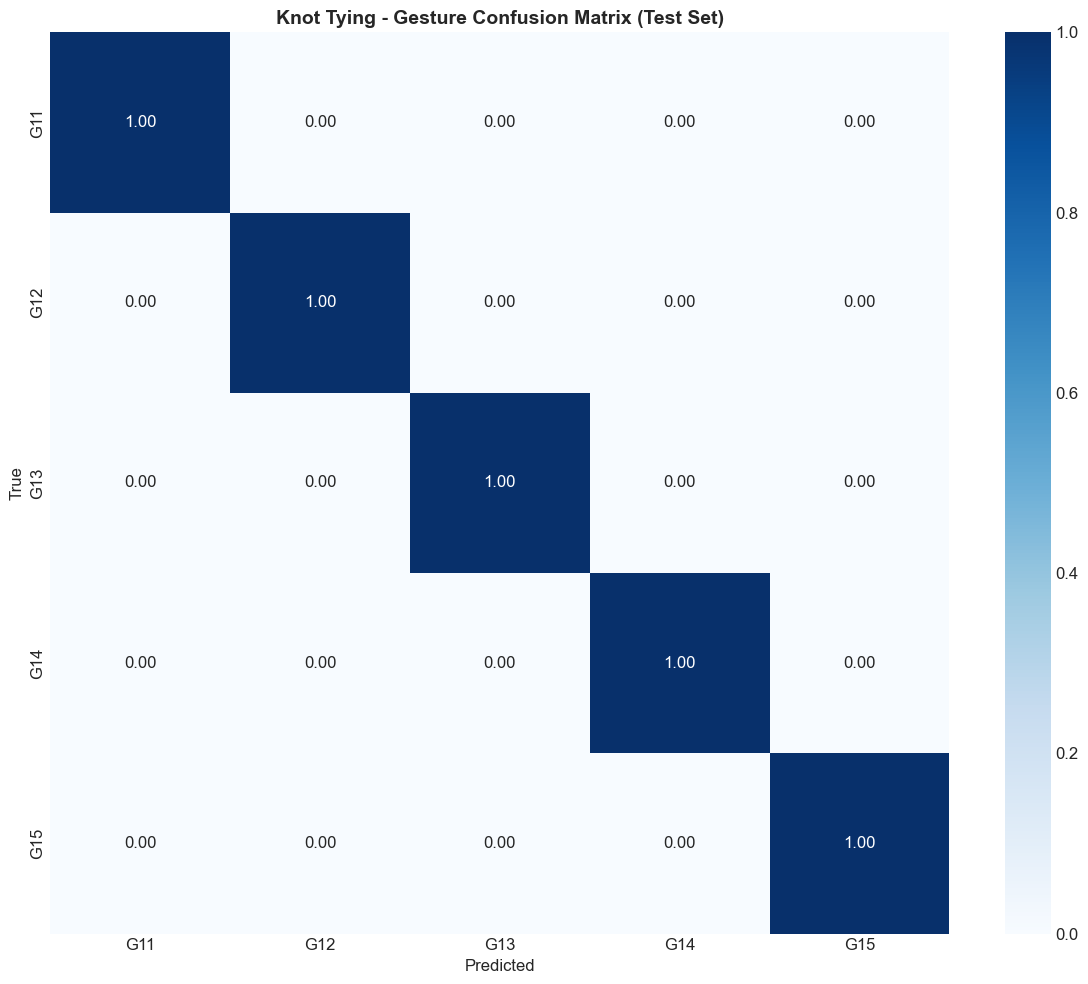

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/knot_tying_gesture_confusion_test_fold_1.png


/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


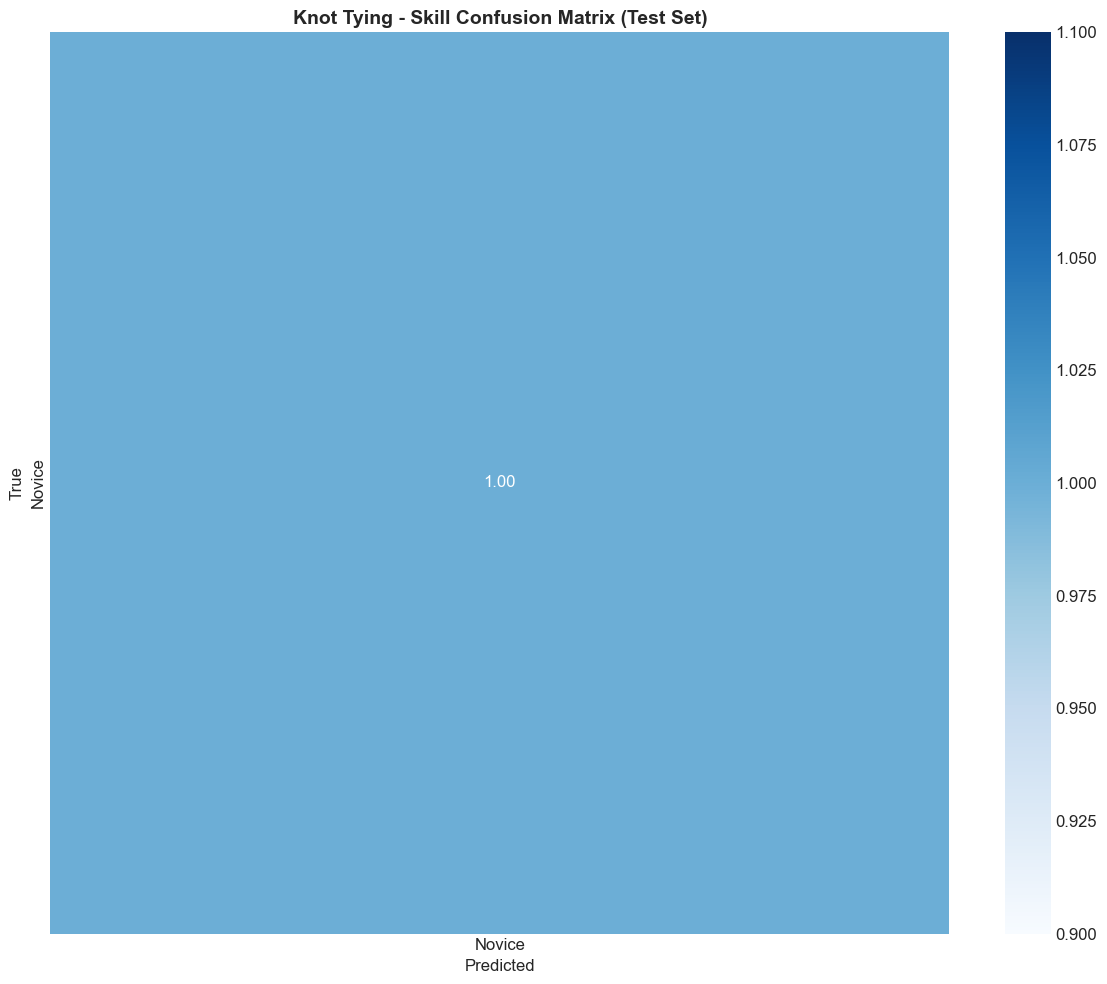

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/knot_tying_skill_confusion_test_fold_1.png

Generating confusion matrix for Needle_Passing
Initializing EEGInformedViTModel
Creating visual encoder: vit_small_patch16_224
  - Pretrained: True
  - Freeze until layer: 6
  - Use adapters: False
Flow encoder: disabled
Creating temporal aggregator...
  - d_model: 384, n_heads: 6, num_layers: 4
Creating kinematics module...
  - d_kin_input: 19, d_kin_output: 19
  - num_gestures: 15, num_skills: 3
Brain RDM: disabled

Model Parameters:
  - Total: 44,975,141 (44.98M)
  - Trainable: 33,957,413 (33.96M)


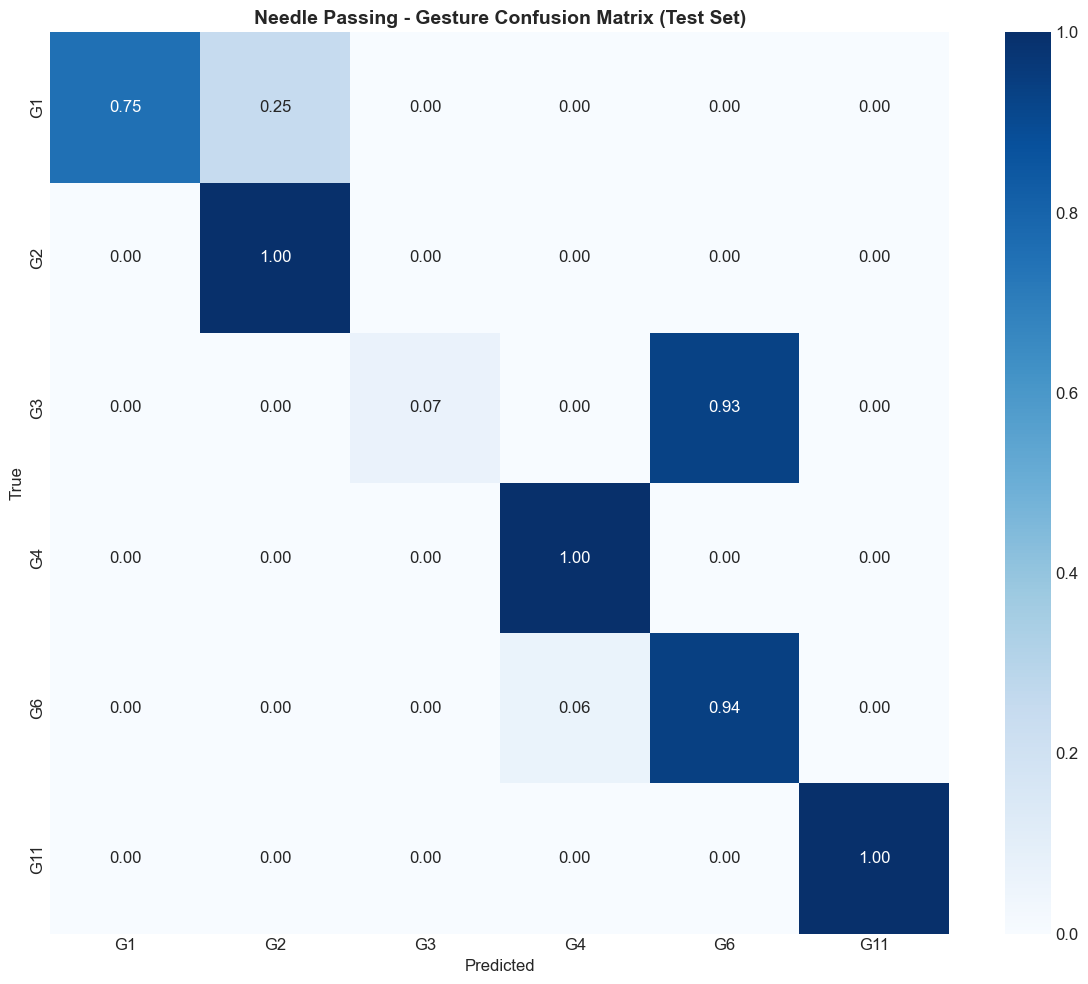

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/needle_passing_gesture_confusion_test_fold_1.png


/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


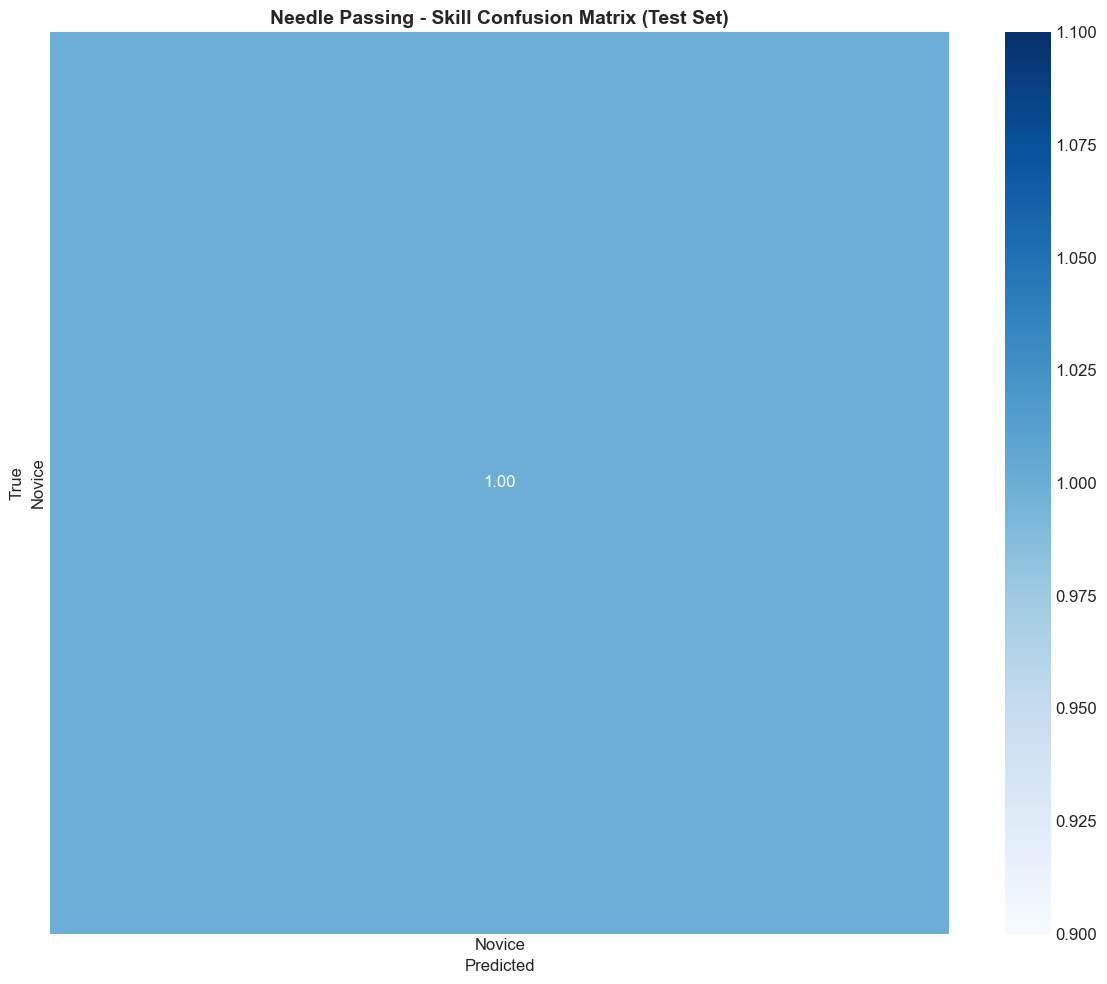

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/needle_passing_skill_confusion_test_fold_1.png

Generating confusion matrix for Suturing
Initializing EEGInformedViTModel
Creating visual encoder: vit_small_patch16_224
  - Pretrained: True
  - Freeze until layer: 6
  - Use adapters: False
Flow encoder: disabled
Creating temporal aggregator...
  - d_model: 384, n_heads: 6, num_layers: 4
Creating kinematics module...
  - d_kin_input: 19, d_kin_output: 19
  - num_gestures: 15, num_skills: 3
Brain RDM: disabled

Model Parameters:
  - Total: 44,975,141 (44.98M)
  - Trainable: 33,957,413 (33.96M)


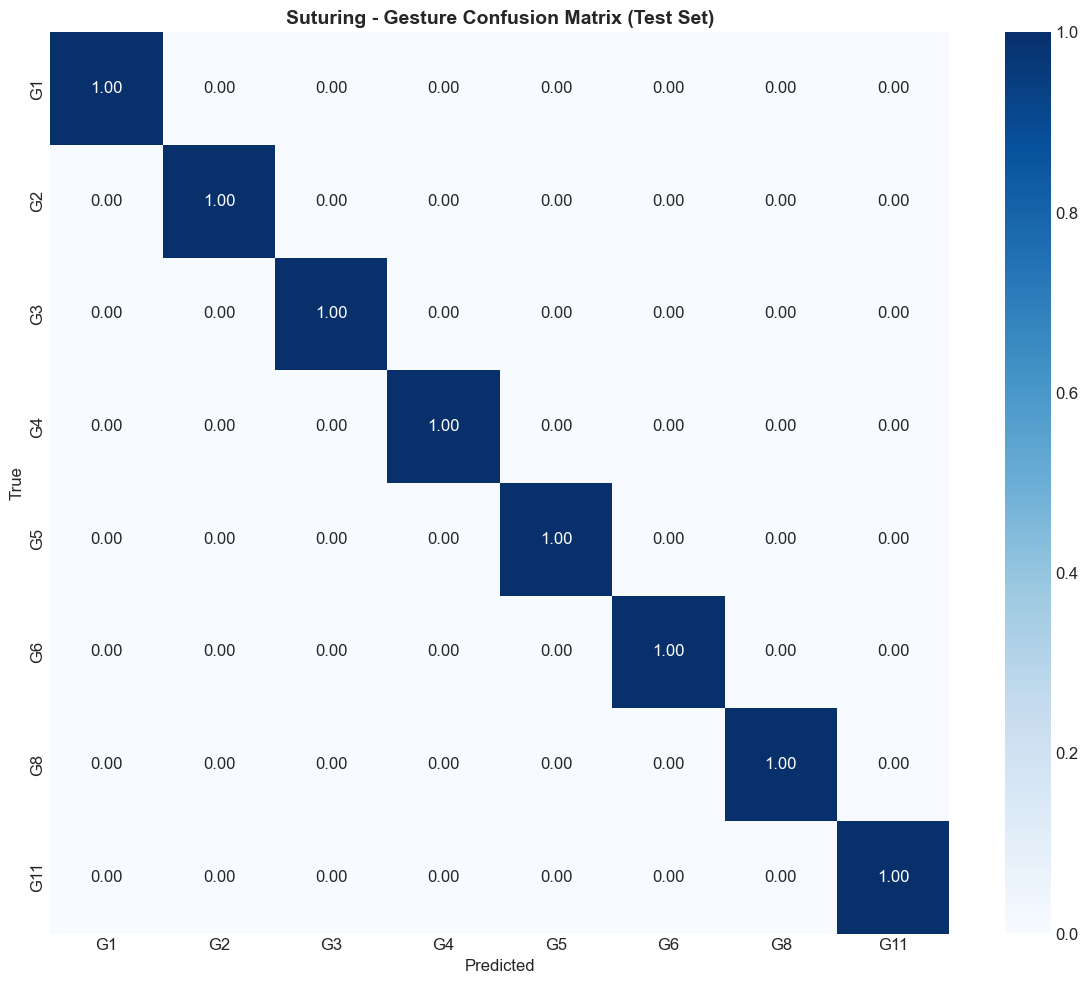

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/suturing_gesture_confusion_test_fold_1.png


/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


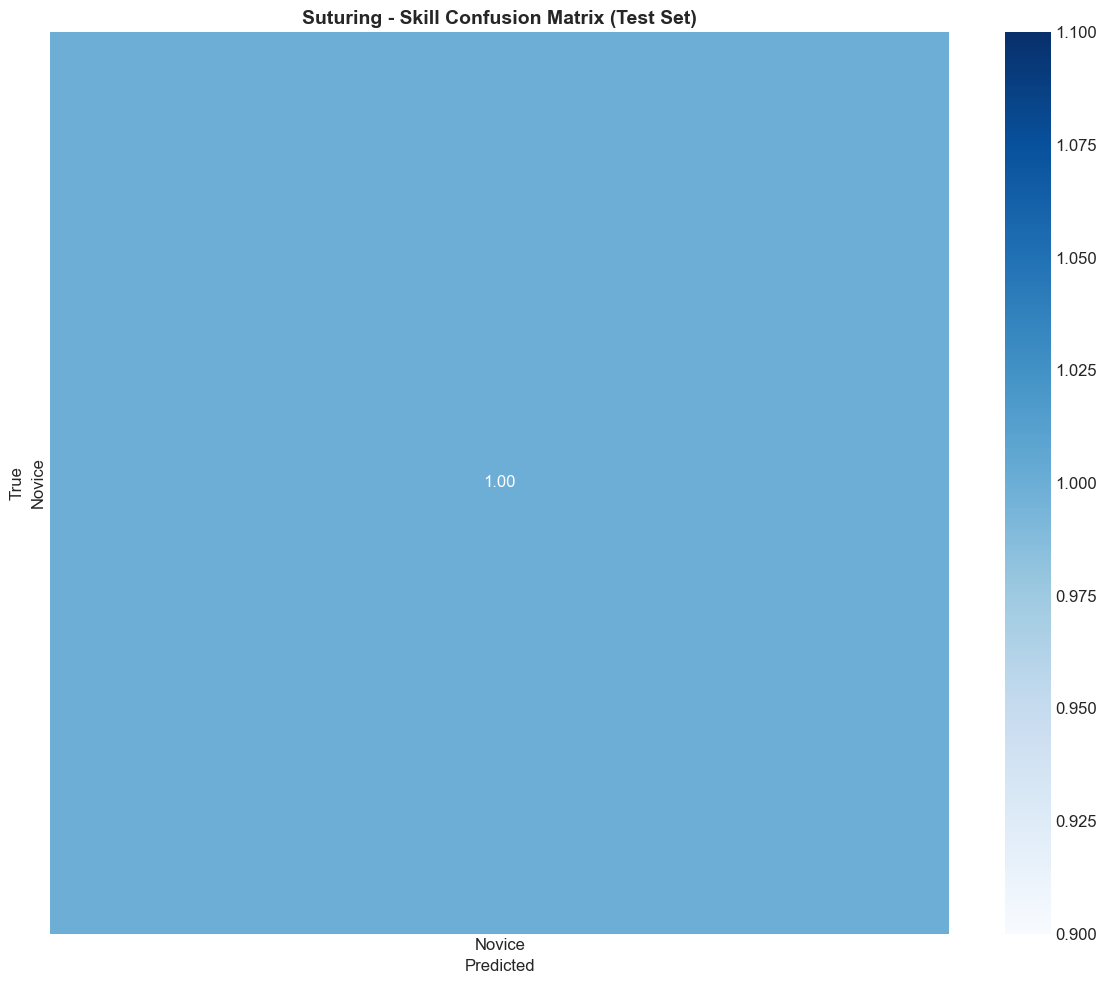

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/suturing_skill_confusion_test_fold_1.png


In [20]:
# Generate confusion matrices for each task
# Note: This requires the trained checkpoints to exist

for task in TASKS:
    task_lower = task.lower()
    checkpoint_path = CHECKPOINT_DIR / f"{task_lower}_{SPLIT}" / "best_model.pth"
    
    if not checkpoint_path.exists():
        print(f"\nCheckpoint not found for {task}: {checkpoint_path}")
        continue
    
    print(f"\n{'='*60}")
    print(f"Generating confusion matrix for {task}")
    print(f"{'='*60}")
    
    try:
        predictions = generate_predictions_from_checkpoint(
            checkpoint_path, task, SPLIT, MODE
        )
        
        # Gesture confusion matrix
        plot_confusion_matrix(
            predictions['gesture_labels'],
            predictions['gesture_preds'],
            GESTURE_LABELS,
            f'{task.replace("_", " ")} - Gesture Confusion Matrix ({MODE.title()} Set)',
            f'{task_lower}_gesture_confusion_{MODE}_{SPLIT}.png'
        )
        
        # Skill confusion matrix
        plot_confusion_matrix(
            predictions['skill_labels'],
            predictions['skill_preds'],
            SKILL_LABELS,
            f'{task.replace("_", " ")} - Skill Confusion Matrix ({MODE.title()} Set)',
            f'{task_lower}_skill_confusion_{MODE}_{SPLIT}.png'
        )
        
    except Exception as e:
        print(f"Error generating confusion matrix for {task}: {e}")
        import traceback
        traceback.print_exc()

## 6. Loss Comparison Across Tasks

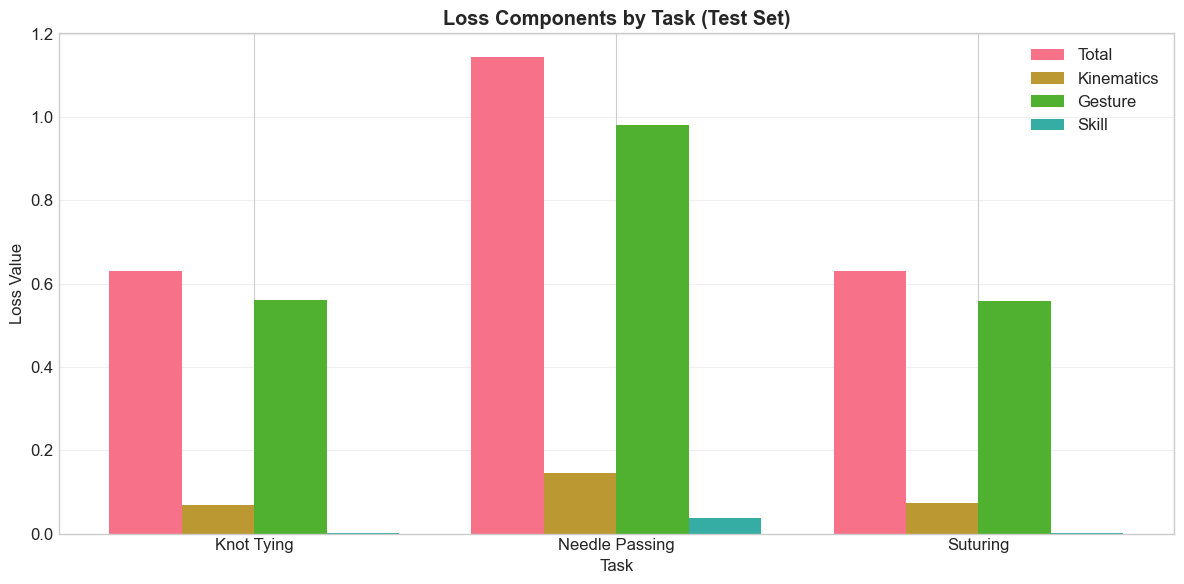

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/loss_comparison_test_fold_1.png


In [21]:
if all_results:
    # Create grouped bar plot for all losses
    fig, ax = plt.subplots(figsize=(12, 6))
    
    tasks = list(all_results.keys())
    loss_types = ['total', 'kinematics', 'gesture', 'skill']
    
    x = np.arange(len(tasks))
    width = 0.2
    
    for i, loss_type in enumerate(loss_types):
        values = [all_results[t]['losses'].get(loss_type, 0) for t in tasks]
        bars = ax.bar(x + i * width, values, width, label=loss_type.title())
    
    ax.set_xlabel('Task')
    ax.set_ylabel('Loss Value')
    ax.set_title(f'Loss Components by Task ({MODE.title()} Set)', fontweight='bold')
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels([t.replace('_', ' ') for t in tasks])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / f'loss_comparison_{MODE}_{SPLIT}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {PLOTS_DIR / f'loss_comparison_{MODE}_{SPLIT}.png'}")

## 7. Radar Chart for Multi-Metric Comparison

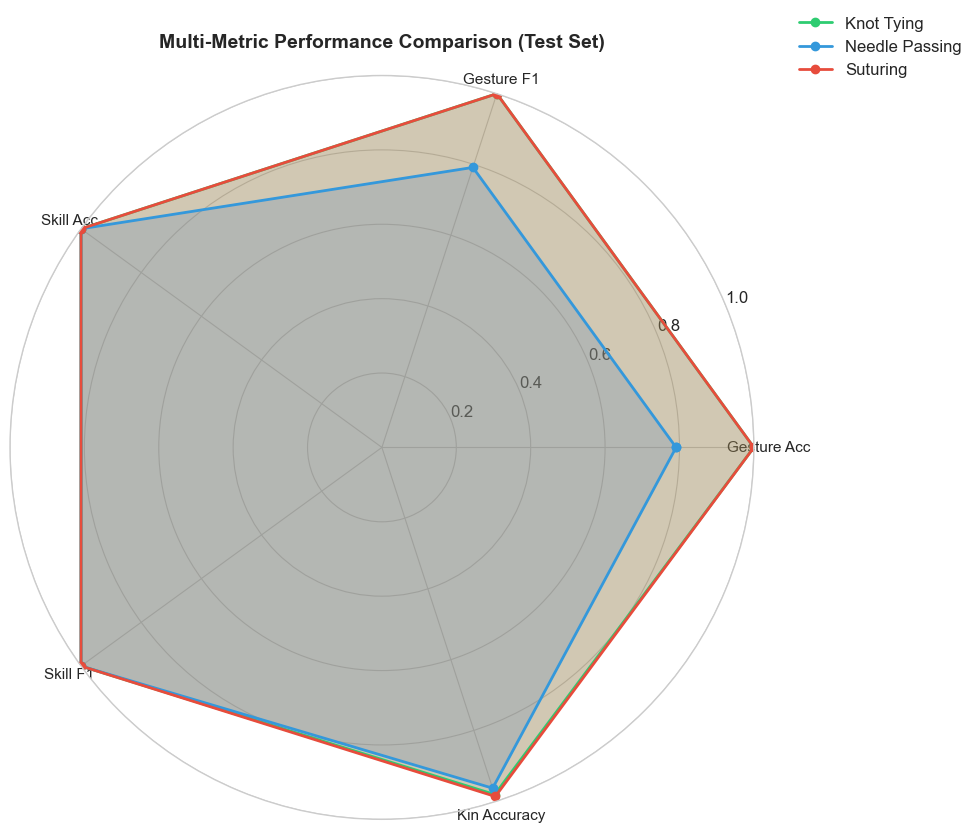

Saved: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results/radar_comparison_test_fold_1.png


In [22]:
def plot_radar_chart(all_results: Dict, filename: str):
    """Create radar chart comparing multiple metrics across tasks."""
    from math import pi
    
    tasks = list(all_results.keys())
    
    # Metrics to compare (normalized to 0-1 scale)
    metrics = {
        'Gesture Acc': lambda r: r['gesture'].get('accuracy', 0) / 100,
        'Gesture F1': lambda r: r['gesture'].get('f1_macro', 0),
        'Skill Acc': lambda r: r['skill'].get('accuracy', 0) / 100,
        'Skill F1': lambda r: r['skill'].get('f1_macro', 0),
        'Kin Accuracy': lambda r: max(0, 1 - r['kinematics'].get('pos_rmse', 1)),  # Inverted RMSE
    }
    
    metric_names = list(metrics.keys())
    N = len(metric_names)
    
    # Compute angles
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the loop
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    for task in tasks:
        values = [metrics[m](all_results[task]) for m in metric_names]
        values += values[:1]  # Complete the loop
        
        ax.plot(angles, values, 'o-', linewidth=2, 
                label=task.replace('_', ' '), color=TASK_COLORS.get(task, '#95a5a6'))
        ax.fill(angles, values, alpha=0.25, color=TASK_COLORS.get(task, '#95a5a6'))
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_names, fontsize=11)
    ax.set_ylim(0, 1)
    ax.set_title(f'Multi-Metric Performance Comparison ({MODE.title()} Set)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {PLOTS_DIR / filename}")

if all_results:
    plot_radar_chart(all_results, f'radar_comparison_{MODE}_{SPLIT}.png')

## 8. Summary Statistics

In [23]:
if all_results:
    print("="*70)
    print(f"SUMMARY: Model Performance on {MODE.upper()} Set ({SPLIT})")
    print("="*70)
    
    for task in all_results:
        r = all_results[task]
        print(f"\n{task.replace('_', ' ')}:")
        print(f"  Gesture: {r['gesture'].get('accuracy', 0):.1f}% accuracy, F1={r['gesture'].get('f1_macro', 0):.4f}")
        print(f"  Skill:   {r['skill'].get('accuracy', 0):.1f}% accuracy, F1={r['skill'].get('f1_macro', 0):.4f}")
        print(f"  Kin:     Pos RMSE={r['kinematics'].get('pos_rmse', 0):.6f}, Rot RMSE={r['kinematics'].get('rot_rmse', 0):.6f}")
    
    # Average across tasks
    print("\n" + "-"*70)
    print("Average across tasks:")
    avg_gesture_acc = np.mean([all_results[t]['gesture'].get('accuracy', 0) for t in all_results])
    avg_gesture_f1 = np.mean([all_results[t]['gesture'].get('f1_macro', 0) for t in all_results])
    avg_skill_acc = np.mean([all_results[t]['skill'].get('accuracy', 0) for t in all_results])
    avg_pos_rmse = np.mean([all_results[t]['kinematics'].get('pos_rmse', 0) for t in all_results])
    
    print(f"  Gesture Accuracy: {avg_gesture_acc:.1f}%")
    print(f"  Gesture F1:       {avg_gesture_f1:.4f}")
    print(f"  Skill Accuracy:   {avg_skill_acc:.1f}%")
    print(f"  Position RMSE:    {avg_pos_rmse:.6f}")
    print("="*70)

SUMMARY: Model Performance on TEST Set (fold_1)

Knot Tying:
  Gesture: 100.0% accuracy, F1=1.0000
  Skill:   100.0% accuracy, F1=1.0000
  Kin:     Pos RMSE=0.018693, Rot RMSE=0.871688

Needle Passing:
  Gesture: 79.1% accuracy, F1=0.7916
  Skill:   100.0% accuracy, F1=1.0000
  Kin:     Pos RMSE=0.036575, Rot RMSE=0.711886

Suturing:
  Gesture: 100.0% accuracy, F1=1.0000
  Skill:   100.0% accuracy, F1=1.0000
  Kin:     Pos RMSE=0.013097, Rot RMSE=1.163411

----------------------------------------------------------------------
Average across tasks:
  Gesture Accuracy: 93.0%
  Gesture F1:       0.9305
  Skill Accuracy:   100.0%
  Position RMSE:    0.022788


In [24]:
print(f"\nAll plots saved to: {PLOTS_DIR}")
print("\nGenerated files:")
for f in sorted(PLOTS_DIR.glob('*.png')):
    print(f"  - {f.name}")


All plots saved to: /Users/michaelhaidar/Documents/Vanderbilt/Fall_25/Surgical Robotics/Surgical_Gestures/plots/results

Generated files:
  - gesture_accuracy_test_fold_1.png
  - gesture_f1_test_fold_1.png
  - knot_tying_gesture_confusion_test_fold_1.png
  - knot_tying_skill_confusion_test_fold_1.png
  - knot_tying_tsne_gesture.png
  - knot_tying_tsne_skill.png
  - loss_comparison_test_fold_1.png
  - needle_passing_gesture_confusion_test_fold_1.png
  - needle_passing_skill_confusion_test_fold_1.png
  - needle_passing_tsne_gesture.png
  - needle_passing_tsne_skill.png
  - performance_summary_test_fold_1.png
  - position_rmse_test_fold_1.png
  - radar_comparison_test_fold_1.png
  - skill_accuracy_test_fold_1.png
  - suturing_gesture_confusion_test_fold_1.png
  - suturing_skill_confusion_test_fold_1.png
  - suturing_tsne_gesture.png
  - suturing_tsne_skill.png
